In [1]:
import sympy as sym
import numpy as np


Determine mass for the system

In [36]:
#grams
mass_frame = 192
mass_rod_each = (mass_frame/5)
mass_motor_each = 59
mass_propellars_each= 28
flight_control_mass = 27 + 28
battery_mass = 528
Esc_mass = 32
reciever_mass = 0.7
m_other = flight_control_mass + Esc_mass + reciever_mass

total_mass = (mass_frame+ mass_motor_each*4  + mass_propellars_each*8+ flight_control_mass + battery_mass + Esc_mass + reciever_mass)
# estimated_thrust_motor = (total_mass*9.81)/4
Lift_each_motor = total_mass/4 # the units are grams so we divide the mass by 4 so each motor will produce this for the weight
# 1023 / 1000 * 9.81 * 4  > lift_each_motor

Endurance_max = ((5300/1000)/(15.5))*60 # when using max current/max motor power


Determine Moment of Inertia for the system

In [3]:
mass_frame = 192/1000
m_rod = (mass_frame/4)*2
l_rod = 363.47/1000
r_motor = (29/2)/1000
h_motor = 24/1000
theta = np.deg2rad(45)
a = 138.69/1000
b = 49.41/1000
c = 46.09/1000
m_battery = 528/1000
m_motor = 59/1000
m_other = 87.7/1000

# no need parallel acis theorem for the rod bc its rotating abt its center
I_rod_y = ((1/12)*m_rod*(l_rod*sym.cos(theta))**2*(sym.sin(theta))**2)*2
I_rod_x = ((1/12)*m_rod*(l_rod*sym.cos(theta))**2*(sym.cos(theta))**2)*2
I_rod_z = ((1/12)*m_rod*(l_rod**2)*2)

#placing motors on top of frame
I_cylinder_y = ((1/4)*m_motor*r_motor**2 + (1/3)*m_motor*h_motor**2 + m_motor*(l_rod/2*sym.sin(theta))**2)*4
I_cylinder_x = ((1/4)*m_motor*r_motor**2 + (1/3)*m_motor*h_motor**2 + m_motor*(l_rod/2*sym.sin(theta))**2)*4
I_cylinder_z = ((1/2)*m_motor*r_motor**2 + m_motor*(l_rod/2)**2)*4

#battery box # cuboid also
Iy = (1/12)*m_battery*(a**2 + c**2)
Ix = (1/12)*m_battery*(b**2 + c**2)
Iz = (1/12)*(m_battery)*(a**2 + b**2)

#esc box # cuboid also
Iy_esc = (1/12)*m_other*(a**2 + c**2)
Ix_esc = (1/12)*m_other*(b**2 + c**2)
Iz_esc = (1/12)*(m_other)*(a**2 + b**2)

#final
Ixx = I_rod_x + I_cylinder_x + Ix + Ix_esc
Iyy = I_rod_y + I_cylinder_y + Iy + Iy_esc
Izz = I_rod_z + I_cylinder_z + Iz + Iz_esc

print(Ixx, Iyy, Izz)

0.00471767170417833 0.00557932168897833 0.011045265556495001


In [4]:
# Drone specs
mass = 0.5    # Drone mass
Ixx = I_rod_x + I_cylinder_x + Ix + Ix_esc  # Moment of inertia in the x direction (calculated above)
Iyy = I_rod_y + I_cylinder_y + Iy + Iy_esc  # Moment of inertia in the y direction (calculated above)
Izz = I_rod_z + I_cylinder_z + Iz + Iz_esc  # Moment of inertia in the z direction (calculated above)

Define variables and matrices pertaining to the drone degrees of freedom

In [5]:
# First 3 degrees of freedom: translation in the x, y, z directions

# Drone position variables in the WORLD FRAME
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# Position matrix (in WORLD FRAME)
p_inW = sym.Matrix([[p_x],
                    [p_y],
                    [p_z]])


# Drone velocity variables in the BODY FRAME
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# Velocity matrix (in WORLD FRAME)
v_inB = sym.Matrix([[v_x],
                    [v_y],
                    [v_z]])


In [6]:
# Second 3 degrees of freedom: rotation in the phi, theta, psi directions

# Drone roll (phi), pitch (theta), and yaw (psi) angles in the WORLD FRAME
phi, theta, psi = sym.symbols('phi, theta, psi')

# Roll, pitch, and yaw rotation matrices that describe orientation in the WORLD FRAME
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T


# Drone angular velocities in the BODY FRAME
w_x, w_y, w_z = sym.symbols('omega_x, omega_y, omega_z')

# Angular velocity matrix (in BODY FRAME)
w_inB = sym.Matrix([[w_x],
                    [w_y],
                    [w_z]])

Define variables and matrices pertaining to system inputs

In [7]:
# Drone moment of inertia matrix
I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

In [24]:
# Drone rotor torque inputs in the BODY FRAME
w_1, w_2, w_3, w_4, h1, h2, h3 = sym.symbols('w_1, w_2, w_3, w_4, h1, h2, h3')

#Thrust coefficient calculation using off the shelf parts
#max RPM
#RPM = KV * Volt
RPM = 800 * 14.8
RPS = RPM / 60
#propeller diameter
Prop_d = 0.23876
#max thrust
g = 9.81 #m/s^2 gravity on Earth
T_m = 1023/1000 * g
#air density
rho = 1.225
#Thrust coefficient
K_T = T_m / (rho * RPS**2 * Prop_d**4)

#drag torque proportioanlity constant
K_d = 0 #set equal to 0 since we are ignoring drag in this model

# Torque matrix (in BODY FRAME)
#The angular speeds have opposite signs as every other motor will rotate in the opposite direction to remove any unwanted moment caused by the motor torques
tau_inB = sym.Matrix([[l_rod/2 * K_T * (w_4**2 - w_2**2)],
                      [l_rod/2 * K_T * (w_3**2 - w_1**2)],
                      [K_d * (w_1**2 - w_2**2 + w_3**2 - w_4**2)]])
tau_inB = sym.simplify(tau_inB)


# Drone vertical z axis forces with force from gravity and force keeping the drone aloft
grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * g]])
grav_inB = R_ofW_inB @ grav_inW # Gravity force converted to body coordinates

head = np.array([
    [h1, -h2, 0],
    [h2,  h1, 0],
    [0, 0, 1]
])

f_z = K_T * (w_1**2 + w_2**2 + w_3**2 + w_4**2) # Drone vertical force
f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [f_z]])
f_inB = head @ R_ofB_inW @ f_inB
f_inB = sym.simplify(f_inB)

Convert the body-fixed velocity to world-fixed velocity to get the derivatives of position (p_dot)

In [48]:
# World frame to body frame p dot
v_inW = R_ofB_inW @ v_inB
p_dot = sym.simplify(v_inW)

Apply [Newton's second law in a rotating frame](https://en.wikipedia.org/wiki/Rotating_reference_frame) to get the derivative of the velocity in body-fixed coordinates.

In [49]:
# 1/m * (thrust and gravity force in body frame - coriolis force)

v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
print("Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:")

# Three decimal places for readability
v_inB_dot = sym.simplify(v_inB_dot)
sym.N(v_inB_dot,3)

Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:


Matrix([
[-1.0*omega_y*v_z + 1.0*omega_z*v_y + 2.0*(h1*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)) + h2*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi)))*(0.0647*w_1**2 + 0.0647*w_2**2 + 0.0647*w_3**2 + 0.0647*w_4**2 - 4.91*cos(phi)*cos(theta)) - 9.81*(h1*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) - h2*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)))*sin(phi)*cos(theta) + 9.81*(h1*cos(psi) - h2*sin(psi))*sin(theta)*cos(theta)],
[ 1.0*omega_x*v_z - 1.0*omega_z*v_x - 2.0*(h1*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi)) - h2*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)))*(0.0647*w_1**2 + 0.0647*w_2**2 + 0.0647*w_3**2 + 0.0647*w_4**2 - 4.91*cos(phi)*cos(theta)) - 9.81*(h1*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + h2*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)))*sin(phi)*cos(theta) + 9.81*(h1*sin(psi) + h2*cos(psi))*sin(theta)*cos(theta)],
[                                                                                                        

Calculate the roll, pitch, and yaw rates as a function of the orientation and body-fixed angular rates.

In [50]:
# Define the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Invert the transformation to get a matrix that takes body-fixed angular rates to
# roll, pitch, and yaw rates
M_inv = sym.simplify(M.inv())

# Convert the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = sym.simplify(M_inv@w_inB)

Use [Euler's Equations](https://en.wikipedia.org/wiki/Euler%27s_equations_(rigid_body_dynamics)) to generate the equations of motion that relate angular velocity to input torque.

In [51]:
# Apply Euler's equation to get the time derivative of the angular velocities of the quadrotor in the quadrotor frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
print("Time derivative of the angular velocities in the body-fixed frame:")
w_inB_dot = sym.simplify(w_inB_dot)
sym.N(w_inB_dot, 3)

Time derivative of the angular velocities in the body-fixed frame:


Matrix([
[-1.16*omega_y*omega_z - 2.49*w_2**2 + 2.49*w_4**2],
[ 1.13*omega_x*omega_z - 2.11*w_1**2 + 2.11*w_3**2],
[                           -0.078*omega_x*omega_y]])

Assemble all differential equations.

In [52]:
f = sym.Matrix.vstack(v_inB_dot,
                      w_inB_dot)

The equations of motion have this form:

$$\begin{bmatrix} \dot{v_x} \\ \dot{v_y} \\ \dot{v_z} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(v_x, v_y, v_z, \phi, \theta, \psi, \omega_x, \omega_y, \omega_z, w_1, w_2, w_3, w_4, h_1, h_2\right)$$

$f$:

In [53]:
sym.N(f,3)

Matrix([
[-1.0*omega_y*v_z + 1.0*omega_z*v_y + 2.0*(h1*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)) + h2*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi)))*(0.0647*w_1**2 + 0.0647*w_2**2 + 0.0647*w_3**2 + 0.0647*w_4**2 - 4.91*cos(phi)*cos(theta)) - 9.81*(h1*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) - h2*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)))*sin(phi)*cos(theta) + 9.81*(h1*cos(psi) - h2*sin(psi))*sin(theta)*cos(theta)],
[ 1.0*omega_x*v_z - 1.0*omega_z*v_x - 2.0*(h1*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi)) - h2*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)))*(0.0647*w_1**2 + 0.0647*w_2**2 + 0.0647*w_3**2 + 0.0647*w_4**2 - 4.91*cos(phi)*cos(theta)) - 9.81*(h1*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + h2*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)))*sin(phi)*cos(theta) + 9.81*(h1*sin(psi) + h2*cos(psi))*sin(theta)*cos(theta)],
[                                                                                                        

Verification 1: Hover 1m above ground for 2 minutes.

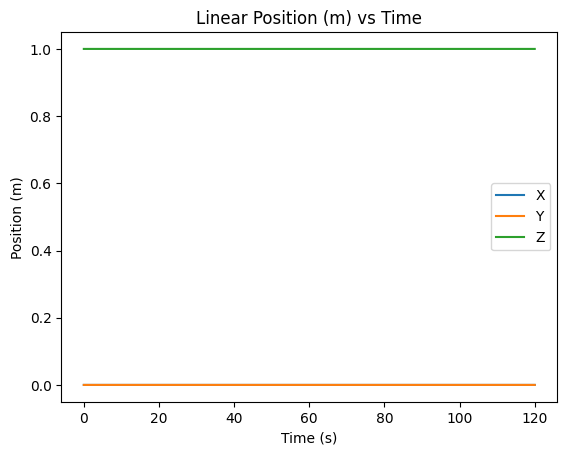

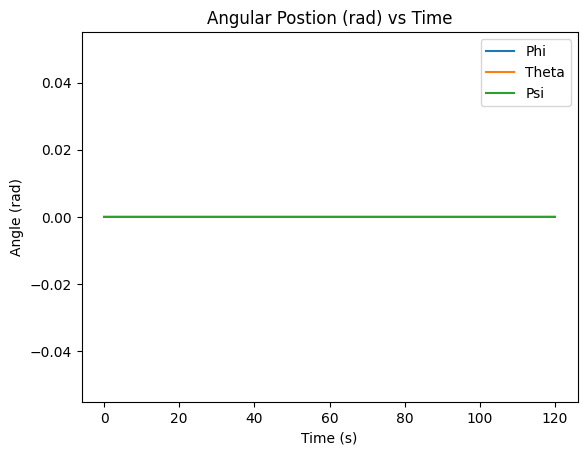

In [56]:
#store equations necessary
lVelEq = p_dot
lAccelEq = v_inB_dot
aVelEq = rpy_dot
aAccelEq = w_inB_dot

#initial conditions
lPos = sym.Matrix([0, 0, 1]) #x,y,z m
lVel = sym.Matrix([0, 0, 0]) #vx,vy,vz m/s
aPos = sym.Matrix([0, 0, 0]) #phi,theta,psi rad
aVel = sym.Matrix([0, 0, 0]) #vphi,vtheta,vpsi rad/s
heading = lVel / sym.sqrt(lVel[0]**2 + lVel[1]**2 + lVel[2]**2)

#Thrust of each motor to counteract weight
T = -grav_inW[2] / 4
#Speed of each motor to produce necessary thrust
w = (T / K_T)**(1/2)

#initial linear and angular acceleration
lAccel = sym.Matrix(lAccelEq.subs({w_x:aVel[0], w_y:aVel[1], w_z:aVel[2], v_x:lVel[0], v_y:lVel[1], v_z:lVel[2],
                                   phi:aPos[0], theta:aPos[1], psi:aPos[2], w_1:w, w_2:w, w_3:w, w_4:w,
                                   h1:heading[0], h2:heading[1], h3:heading[2]}))
if abs(lAccel[2]) < 1e-12:
  lAccel[2] = 0
aAccel = aAccelEq.subs({w_x:aVel[0], w_y:aVel[1], w_z:aVel[2], w_1:w, w_2:w, w_3:w, w_4:w})

#create contianers for values over time
t_vals = []
lPos_vals = []
lVel_vals = []
lAccel_vals = []
aPos_vals = []
aVel_vals = []
aAccel_vals = []

#iterate the eoms over 2 minutes (120 seconds) updating every 0.01 seconds (12001 loops)
dt = 0.01 #s
for t in range(12001):
  #append the current values to the list for each time step
  t_vals.append(t*dt)
  lPos_vals.append(lPos)
  lVel_vals.append(lVel)
  lAccel_vals.append(lAccel)
  aPos_vals.append(aPos)
  aVel_vals.append(aVel)
  aAccel_vals.append(aAccel)

  #determine the current acceleration during the timestep
  lAccel = sym.Matrix(lAccelEq.subs({w_x:aVel[0], w_y:aVel[1], w_z:aVel[2], v_x:lVel[0], v_y:lVel[1], v_z:lVel[2],
                                     phi:aPos[0], theta:aPos[1], psi:aPos[2], w_1:w, w_2:w, w_3:w, w_4:w,
                                     h1:heading[0], h2:heading[1], h3:heading[2]})) #the motor speeds will not change while hovering
  if abs(lAccel[2]) < 1e-12:
    lAccel[2] = 0 #set the tolerance at 1e-12 for calculations slightly off from numpy or sympy
  #update other values accordingly
  lPos = lPos + lVel * dt
  lVel = lVel + lAccel * dt
  heading = lVel / sym.sqrt(lVel[0]**2 + lVel[1]**2 + lVel[2]**2)
  #determine the current angular acceleration during the timestep
  aAccel = aAccelEq.subs({w_x:aVel[0], w_y:aVel[1], w_z:aVel[2], w_1:w, w_2:w, w_3:w, w_4:w}) #the motor speeds will not change while hovering
  #update other values accordingly
  aPos = aPos + aVel * dt
  aVel = aVel + aAccel * dt

#extract x, y, z, phi, theta, ans psi values from the lists
lPos_valsX = [pos[0] for pos in lPos_vals]
lPos_valsY = [pos[1] for pos in lPos_vals]
lPos_valsZ = [pos[2] for pos in lPos_vals]
aPos_valsPhi = [pos[0] for pos in aPos_vals]
aPos_valsTheta = [pos[1] for pos in aPos_vals]
aPos_valsPsi = [pos[2] for pos in aPos_vals]

#import matplotlib
from matplotlib import pyplot as plt

#plot out the translational and angular positioning of the drone over 2 minutes of hovering
plt.plot(t_vals, lPos_valsX, label="X")
plt.plot(t_vals, lPos_valsY, label="Y")
plt.plot(t_vals, lPos_valsZ, label="Z")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Linear Position (m) vs Time')
plt.legend()
plt.show()

plt.plot(t_vals, aPos_valsPhi, label="Phi")
plt.plot(t_vals, aPos_valsTheta, label="Theta")
plt.plot(t_vals, aPos_valsPsi, label="Psi")
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angular Postion (rad) vs Time')
plt.legend()
plt.show()


Verification 2: Fly in a circle of radius 2m, at an altitude of 1m above ground at a speed
of 0.5m/s for at least 1 minute.

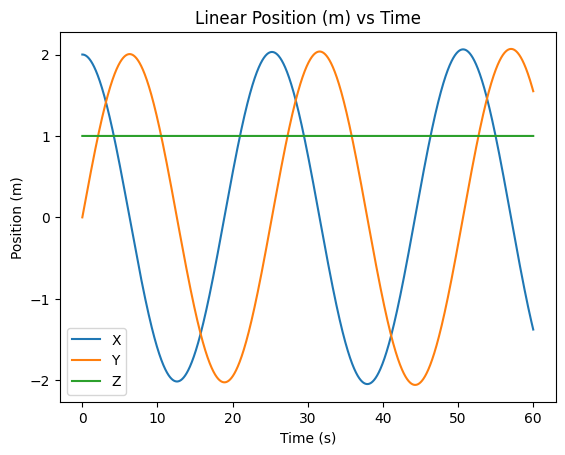

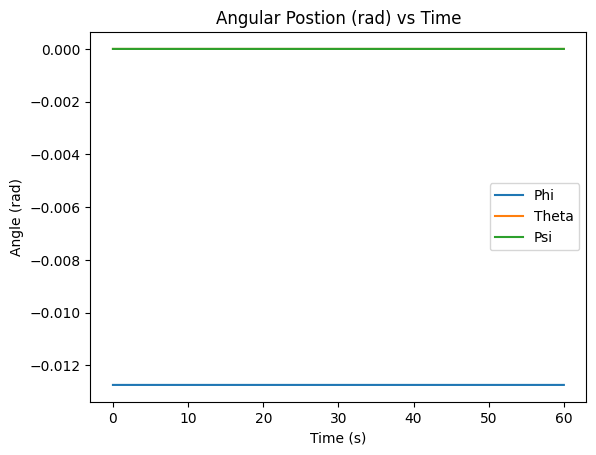

In [55]:
#store equations necessary
lVelEq = p_dot
lAccelEq = v_inB_dot
aVelEq = rpy_dot
aAccelEq = w_inB_dot

#initial conditions
a_c = -0.5**2 / 2
a_v = g
i_phi = sym.atan2(a_c, a_v)

lPos = sym.Matrix([2, 0, 1]) #x,y,z m
lVel = sym.Matrix([0, 0.5, 0]) #vx,vy,vz m/s
aPos = sym.Matrix([i_phi, 0, 0]) #phi,theta,psi rad
aVel = sym.Matrix([0, 0, 0]) #vphi,vtheta,vpsi rad/s
#set the heading up (direction in which the drone is moving)
heading = lVel / sym.sqrt(lVel[0]**2 + lVel[1]**2 + lVel[2]**2)

#Thrust of each motor to counteract weight and spin in a circle
T = mass * sym.sqrt(a_c**2 + a_v**2) / 4  #The vertical force defined above needs to change because it only works if the drone is in a nuetral position (basically just need to add angle dependence)
#Speed of each motor to produce necessary thrust
w = (T / K_T)**(1/2)

#initial linear and angular acceleration
lAccel = sym.Matrix(lAccelEq.subs({w_x:aVel[0], w_y:aVel[1], w_z:aVel[2], v_x:lVel[0], v_y:lVel[1], v_z:lVel[2],
                                   phi:aPos[0], theta:aPos[1], psi:aPos[2], w_1:w, w_2:w, w_3:w, w_4:w,
                                   h1:heading[0], h2:heading[1], h3:heading[2]}))
if abs(lAccel[2]) < 1e-12:
  lAccel[2] = 0
aAccel = aAccelEq.subs({w_x:aVel[0], w_y:aVel[1], w_z:aVel[2], w_1:w, w_2:w, w_3:w, w_4:w})

#create contianers for values over time
t_vals = []
lPos_vals = []
lVel_vals = []
lAccel_vals = []
aPos_vals = []
aVel_vals = []
aAccel_vals = []

#iterate the eoms over 2 minutes (120 seconds) updating every 0.01 seconds (12001 loops)
dt = 0.01 #s
for t in range(6001): #only doing 10 seconds rn to get it working
  #append the current values to the list for each time step
  t_vals.append(t*dt)
  lPos_vals.append(lPos)
  lVel_vals.append(lVel)
  lAccel_vals.append(lAccel)
  aPos_vals.append(aPos)
  aVel_vals.append(aVel)
  aAccel_vals.append(aAccel)

  #determine the current acceleration during the timestep
  lAccel = sym.Matrix(lAccelEq.subs({w_x:aVel[0], w_y:aVel[1], w_z:aVel[2], v_x:lVel[0], v_y:lVel[1], v_z:lVel[2],
                                     phi:aPos[0], theta:aPos[1], psi:aPos[2], w_1:w, w_2:w, w_3:w, w_4:w,
                                     h1:heading[0], h2:heading[1], h3:heading[2]})) #the motor speeds will not change while hovering
  if abs(lAccel[2]) < 1e-12:
    lAccel[2] = 0 #set the tolerance at 1e-10 for calculations slightly off from numpy
  #update other values accordingly
  lPos = lPos + lVel * dt
  lVel = lVel + lAccel * dt
  #update heading
  heading = lVel / sym.sqrt(lVel[0]**2 + lVel[1]**2 + lVel[2]**2)
  #determine the current angular acceleration during the timestep
  aAccel = aAccelEq.subs({w_x:aVel[0], w_y:aVel[1], w_z:aVel[2], w_1:w, w_2:w, w_3:w, w_4:w}) #the motor speeds will not change while hovering
  #update other values accordingly
  aPos = aPos + aVel * dt
  aVel = aVel + aAccel * dt

#extract x, y, z, phi, theta, ans psi values from the lists
lPos_valsX = [pos[0] for pos in lPos_vals]
lPos_valsY = [pos[1] for pos in lPos_vals]
lPos_valsZ = [pos[2] for pos in lPos_vals]
aPos_valsPhi = [pos[0] for pos in aPos_vals]
aPos_valsTheta = [pos[1] for pos in aPos_vals]
aPos_valsPsi = [pos[2] for pos in aPos_vals]

#import matplotlib
from matplotlib import pyplot as plt

#plot out the translational and angular positioning of the drone over 1 minutes of flying in a circle
plt.plot(t_vals, lPos_valsX, label="X")
plt.plot(t_vals, lPos_valsY, label="Y")
plt.plot(t_vals, lPos_valsZ, label="Z")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Linear Position (m) vs Time')
plt.legend()
plt.show()

plt.plot(t_vals, aPos_valsPhi, label="Phi")
plt.plot(t_vals, aPos_valsTheta, label="Theta")
plt.plot(t_vals, aPos_valsPsi, label="Psi")
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angular Postion (rad) vs Time')
plt.legend()
plt.show()
